* 책 내용 안에서만 이해
* 연습

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
### JUPYTER NOTEBOOK EAGER LOAD ###
import io, os, sys, types, re
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def get_chapter_number(file_name):
    hit = re.match(r'(?P<chapter>\d+)\..*', file_name)
    return int(hit['chapter'])

files = !ls *.ipynb
files = sorted(files, key=lambda f: int(f.split('.')[0]))
files = filter(lambda file: get_chapter_number(file) < get_chapter_number(theNotebook), files)

nbs = []
for file in files:
    with io.open(file, 'r', encoding='utf-8') as f:
        nbs.append(read(f, 4))

each_code_cells = []
for nb in nbs:
    each_code_cells.append(filter(lambda c: c['cell_type'] == 'code', nb.cells))

for code_cells in each_code_cells:
    for code_cell in code_cells:
        code = InteractiveShell.instance().input_transformer_manager.transform_cell(code_cell.source)
        try:
            if code.split("\n")[0] == '### JUPYTER NOTEBOOK EAGER LOAD ###': continue
            get_ipython().run_cell_magic('capture', '', code)
        except RuntimeError:
            continue

지원자가 면접에 합격/불합격할 지 예측하기 -> 의사결정나무 사용

In [16]:
inputs = [
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
    ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
    ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
    ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
    ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
    ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
]

# What Is a Decision Tree?
* 나무
* 가능한 결정 경로 - 가지
* 결과 - 잎
* 질문(특징) - 노드


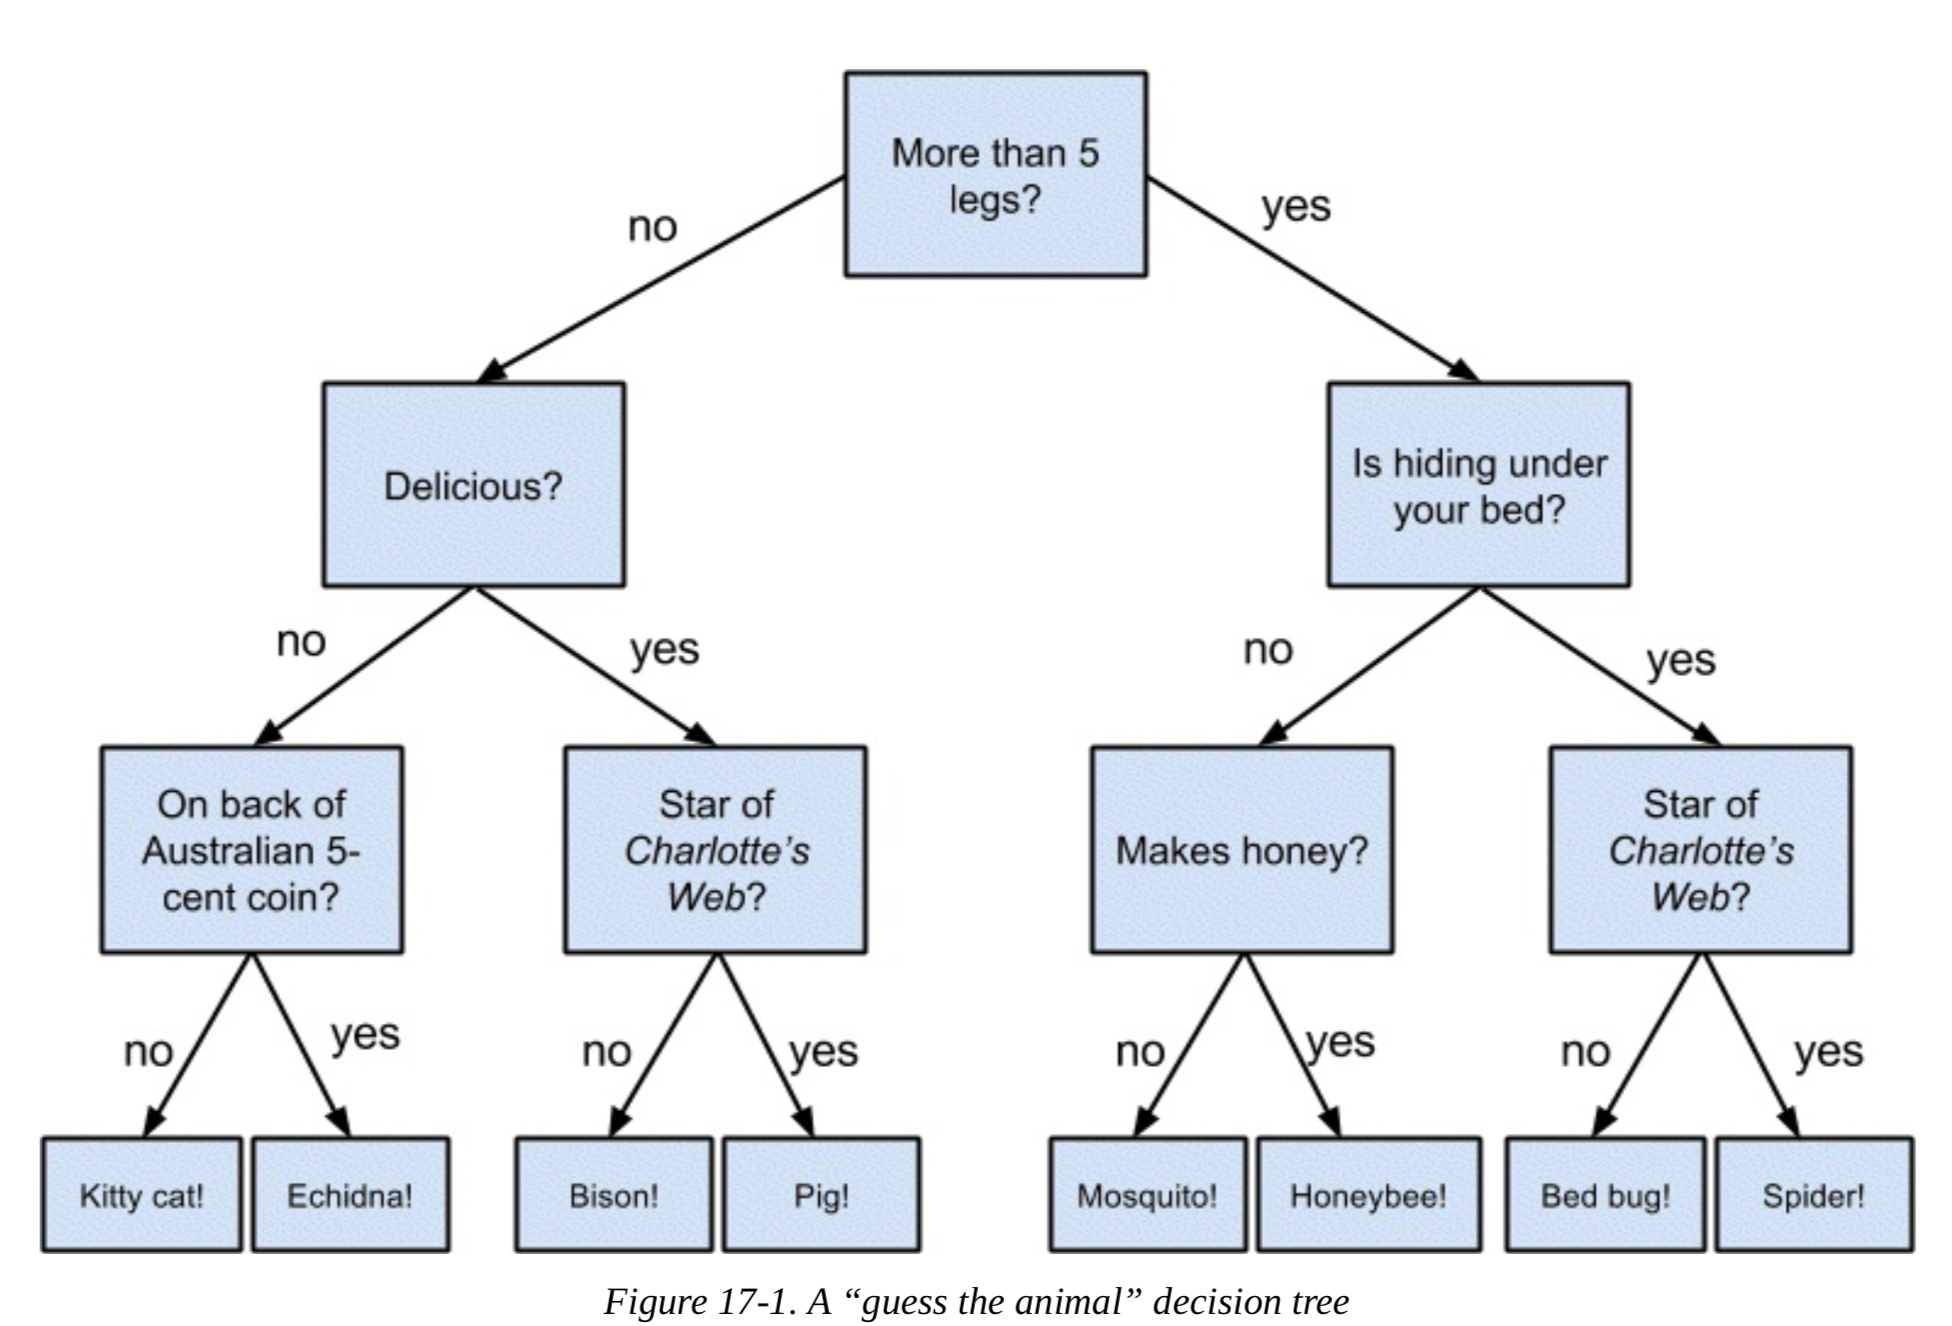 

[echidna](https://en.wikipedia.org/wiki/Echidna)

## 장점
* 이해와 해석이 쉽다
* 투명한 예측 프로세스
* 숫자(numerical)와 범주형(categorical) 데이터 모두 다룰 수 있고 어떤 특징(attribute)이 없더라도 예측 가능

## 단점
* 최선의 의사결정나무를 계산하기 어렵다(적당히 좋은 의사결정나무 만들기)
* 훈련 데이터에 오버피팅하기 쉽다

## 종류
* 분류 나무(classification trees)
* ~~회귀 나무(regression trees)~~

labeled data?


# Entropy
* 엔트로피 = disorder(무질서) = uncertainty(in data, 불확실성) (=반반이면 불확실, 모 아니면 도 확실?)
* 질문(=attribute)의 순서를 정함 

In [11]:
%%latex
$H(s) = -p_1log_2p_1 - ... -p_nlog_2p_n  (단, 0log0 = 0)$

<IPython.core.display.Latex object>

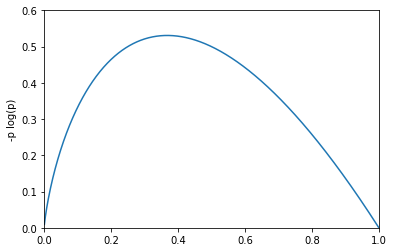

In [12]:
def entropy(probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in probabilities if p)

xs = [x * .001 for x in range(1, 1001)]
ys = [-x * math.log(x, 2) for x in xs]
plt.xlim(0, 1)
plt.ylim(0, 0.6)
plt.ylabel('-p log(p)')
plt.plot(xs, ys)
plt.show()

(다 더하기 때문에) 각 확률 값만 알면 된다

In [13]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels= [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

# The Entropy of a Partition

In [14]:
%%latex
$H = q_1H(S_1) + ... + q_mH(S_m)$

<IPython.core.display.Latex object>

In [15]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets
    subsets is a list of lists of labeled data"""
    
    total_count = sum(len(subset) for subset in subsets)
    
    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

# Creating a Decision Tree

In [17]:
def partition_by(inputs, attribute):
    """each input is a pair (attribute_dict, label).
    returns a dict : attribute_value -> inputs"""
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the value of specified attribute
        groups[key].append(input) # then add this input to the correct list
    return groups

In [18]:
def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

In [19]:
for key in inputs[0][0].keys():
    print(key, partition_entropy_by(inputs, key))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


In [20]:
senior_inputs = [(input, label)
                 for input, label in inputs if input['level'] == 'Senior']

for key in inputs[0][0].keys():
    if key != 'level':
        print(key, partition_entropy_by(senior_inputs, key))

lang 0.4
tweets 0.0
phd 0.9509775004326938


In [21]:
junior_inputs = [(input, label)
                 for input, label in inputs if input['level'] == 'Junior']

for key in inputs[0][0].keys():
    if key != 'level':
        print(key, partition_entropy_by(junior_inputs, key))

lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


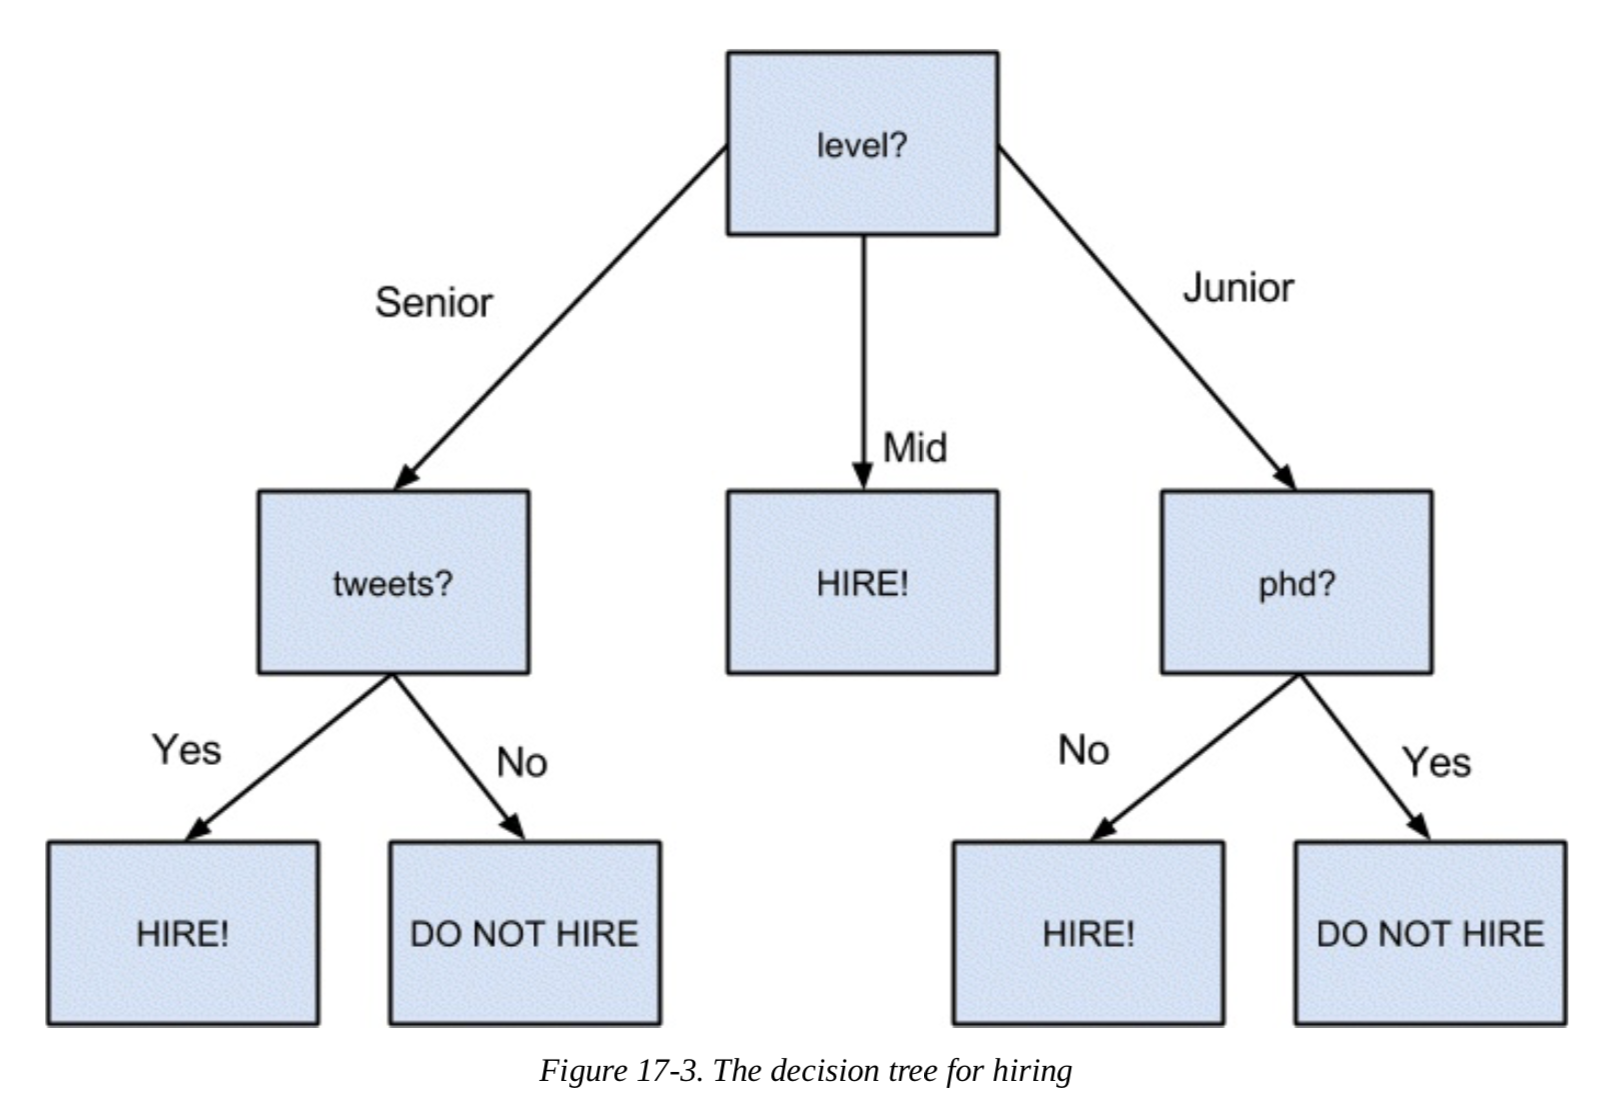

# Putting It All together

* if 데이터가 모두 같은 분류이면(같은 label이면), 그 label로 예측하는 잎을 만들고 종료.
* if 고를 특징이 더 이상 없으면(할 질문이 더 이상 없으면), label을 다수결로 예측하고 잎을 만들어 종료.
* (else) 특징에 따라 데이터 파티션.
* 파티션 엔트로피가 가장 낮은 파티션 고르기.
* 결정 노드(특징 = 질문) 생성.
* 파티션 subset에 대하여 재귀 호출.

id3 - 탐욕 알고리즘, 전체적으로 최선의 선택이 아닐 수 있으나 구현과 이해가 쉬워서 사용

## 나타내기(`dict`)
* `True`
* `False`
* a tuple `(attribute, subtree_dict)`

학습 때 못보던 데이터가 들어오면? -> `None`에 다수결로 label 결정

In [27]:
tree_in_hand= ('level',
                  {'Junior': ('phd',{'no': True, 'yes': False}),
                   'Mid': True,
                   'Senior': ('tweets', {'no': False, 'yes': True})})
tree_in_hand

('level',
 {'Junior': ('phd', {'no': True, 'yes': False}),
  'Mid': True,
  'Senior': ('tweets', {'no': False, 'yes': True})})

In [23]:
def build_tree_id3(inputs, split_candidates=None):
    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
        
    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    if num_trues == 0: return False    # no Trues? return a "False" leaf
    if num_falses == 0: return True    # no Falses? return a "True" leaf
    
    if not split_candidates:           # if no split candidates left
        return num_trues >= num_falses # return the majority leaf
    
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
                         key=partial(partition_entropy_by, inputs))
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = {attribute_value: build_tree_id3(subset, new_candidates)
                for attribute_value, subset in partitions.items()}
    
    subtrees[None] = num_trues > num_falses # default case
    
    return (best_attribute, subtrees)

In [24]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    
    # if this is a leaf noe , return its value
    if tree in [True, False]:
        return tree
    
    # otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)  # None if input is missing attribute
    
    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree
        
    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input

In [26]:
tree = build_tree_id3(inputs)
tree

('level',
 {'Junior': ('phd', {None: True, 'no': True, 'yes': False}),
  'Mid': True,
  None: True,
  'Senior': ('tweets', {None: False, 'no': False, 'yes': True})})

In [29]:
classify(tree, {"level" : "Junior",
                "lang": "Java",
                "tweets": "yes",
                "phd": "no"})

True

In [30]:
classify(tree,{"level": "Junior",
               "lang": "Java",
               "tweets" : "yes",
               "phd": "yes"})

False

In [31]:
classify(tree, {'level': 'Intern'})

True

In [32]:
classify(tree, {'level': 'Senior'})

False

## Random Forests
* 오버피팅을 피하는 방법
* 여러 나무(forest)를 만들고 다수결로 결정

In [33]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    votes_count = Counter(votes)
    return vote_counts.most_common(1)[0][0]

## bootstraping으로 random한 나무 만들기
* 다른 데이터(`bootstrap_sample(inputs)`)로 만들기 때문에 다 다른 나무가 만들어집니다.
* nonsampled 데이터로 테스트할 수 있다 = 성능 측정 방법을 잘 설계하면 전체 데이터를 학습에 쓸 수 있다.

## 랜덤하게 파티션
* 특징 중 일부만 선택해 파티션
* 남은 특징이 너무 적으면 전부 사용해서 파티션
```python
# if there's already few enough split candidates, look at all of them
if len(split_candidates) <= self.num_split_candidates:
    sampled_split_candidates = split_candidates
# otherwise pick a random sample
else:
    sampled_split_candidates = random.sample(split_candidates,
                                             self.num_split_candidates)
    
# now choose the best attribute only from those candidates
best_attribute = min(sampled_split_candidates,
                     key=partial(partial_entropy_by, inputs))

partitions = partition_by(inputs, best_attribute)
```